# Calibration overview


An image of the sky contains counts from several sources. The task of data reduction (another name for image calibration) is to remove all non-celestial counts from the image and to correct for non-uniform sensitivity.

At the end of the previous notebook we arrived at an expression for the counts in a science image in terms of the sources of counts:

$$
\text{raw image} = \text{bias} + \text{noise} + \text{dark current} + \text{flat} \times (\text{sky} + \text{stars}).
$$

Solving for the counts just from the stars is as follows:

$$
\text{stars} + \text{noise} = \frac{\text{raw image} - \text{bias} - \text{dark current}}{\text{flat}} - \text{sky}
$$

#### It is *impossible* to remove the noise from the raw image because the noise is random.

The dark current is typically calculated from a *dark frame* (aka dark image). Such an image has bias and read noise in it as well, so:

$$
\text{dark current} + \text{noise} = (\text{dark frame} - \text{bias})/(\text{dark exposure time})
$$

Once again, note that the noise cannot be removed.

## This noise cannot be removed from CCD images

To demonstrate that you cannot remove the noise from an image, let's construct an image with just stars and noise and try to subtract a noise image created with the same parameters. The amount of noise here is exaggerated to make it clear in the images.

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

from astropy.visualization import hist
from astropy.stats import histogram

import image_sim as imsim
from convenience_functions import show_image

### FIrst, some stars with noise

The image below shows stars but shows quite a bit of noise as well.

(10.0, 10)


Text(0.5,1,'Stars with noise')

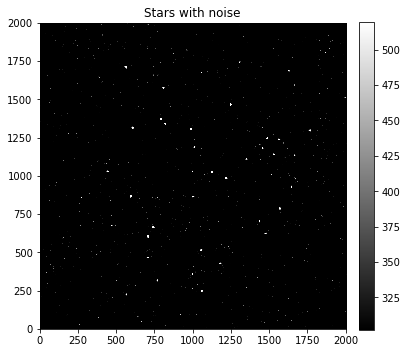

In [2]:
image = np.zeros([2000, 2000])
gain = 1.0
noise_amount = 500 

stars_with_noise = imsim.stars(image, 50, max_counts=2000) + imsim.read_noise(image, noise_amount, gain=gain)

show_image(stars_with_noise, cmap='gray', percu=99.9)
plt.title('Stars with noise')

### Now an *incorrect* attempt at reducing noise

Notice that the call to the noise function has exactly the same arguments as above, in much the same way your camera's electronics will have the same noise properties every time you read out an image.

However, the amount of noise has **increased**, not decreased. It's much harder to pick out the stars in this image.

(10.0, 10)


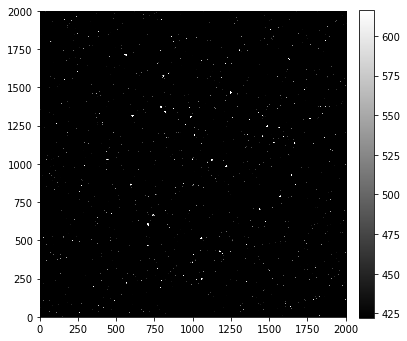

In [3]:
incorrect_attempt_to_remove_noise = stars_with_noise - imsim.read_noise(image, noise_amount, gain=gain)

show_image(incorrect_attempt_to_remove_noise, cmap='gray', percu=99.9)

## Every image has noise

Every image, including calibration images like bias and dark frames, has noise. If we tried to calibrate images by taking a single bias image and a single dark image, the final result might well look worse than before the image is reduced.

For demonstration, we'll see what happens below.

Note that here we construct *realistic* bias and dark, but leave read noise out of the flat; we'll return to that point later. 

### First, set parameters for the CCD

These are the same as in the previous notebook, except for the read noise, which is 700$e-$, 100 times larger than in the previous notebook.

In [4]:
gain = 1.0
star_exposure = 30.0
dark_exposure = 60.0
dark = 0.1
sky_counts = 20
bias_level = 1100
read_noise_electrons = 700
max_star_counts = 2000

### Generate the images, with noise

In [5]:
bias_with_noise = (imsim.bias(image, bias_level, realistic=True) + 
                   imsim.read_noise(image, read_noise_electrons, gain=gain))

dark_frame_with_noise = (imsim.bias(image, bias_level, realistic=True) + 
                         imsim.dark_current(image, dark, dark_exposure, gain=gain, hot_pixels=True) +
                         imsim.read_noise(image, read_noise_electrons, gain=gain))

flat = imsim.sensitivity_variations(image)

/Users/mattcraig/development/ccd-reduction-and-photometry-guide/notebooks/image_sim.py:121: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain


In [6]:
realistic_stars = (imsim.stars(image, 50, max_counts=max_star_counts) +
                   imsim.dark_current(image, dark, star_exposure, gain=gain, hot_pixels=True) +
                   imsim.bias(image, bias_level, realistic=True) +
                   imsim.read_noise(image, read_noise_electrons, gain=gain)
                  )

/Users/mattcraig/development/ccd-reduction-and-photometry-guide/notebooks/image_sim.py:121: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain


### Uncalibrated image

Below we display the uncalibrated image; in a moment we'll compare it to the calibrated version. Even though they don't stand out there really are stars in  it.

(9.0, 9)


<Figure size 864x864 with 0 Axes>

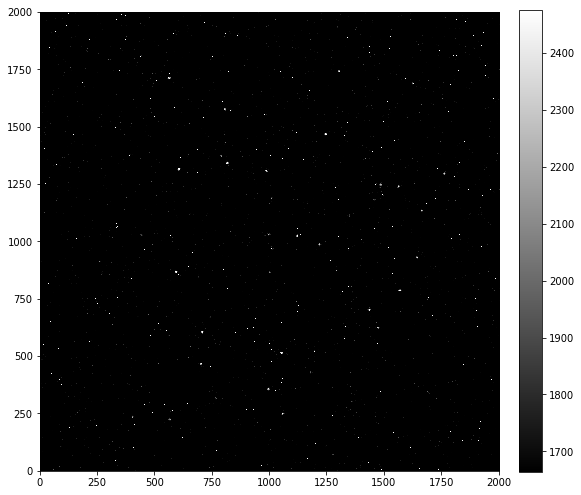

In [7]:
plt.figure(figsize=(12, 12))
show_image(realistic_stars, cmap='gray', percu=99.9, figsize=(9, 9))

### Reduce (calibrate) the star image

First we calculate the dark current, scaled to the exposure time of our light image.

In [8]:
scaled_dark_current = star_exposure * (dark_frame_with_noise - bias_with_noise) / dark_exposure

Next, we subtract the bias and dark current from the star image and then apply the flat correction.

In [9]:
calibrated_stars = (realistic_stars - bias_with_noise - scaled_dark_current) / flat

(10.0, 10)


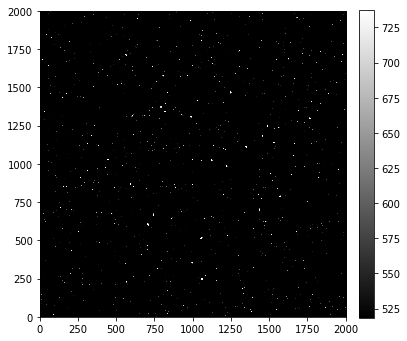

In [10]:
show_image(calibrated_stars, cmap='gray', percu=99.9)

### Reducing the image cleans up the image a bit

The stars stand more clearly than in the unreduced image.

This image does not look *much* better than the uncalibrated image, but remember that the read noise used in this simulated image, 700 $e^-$ per pixel, is unrealistically high. 

### Reducing the image increases the noise in the image

The histogram below shows pixel values before and after calibration. The width of the distribution is a measure of the read noise. As expected, reducing the image increases the read noise. One reason one takes several calibration images of each type is to reduce the amount of noise in the calibration image. That will, in turn, keep the noise in the final image as small as possible.

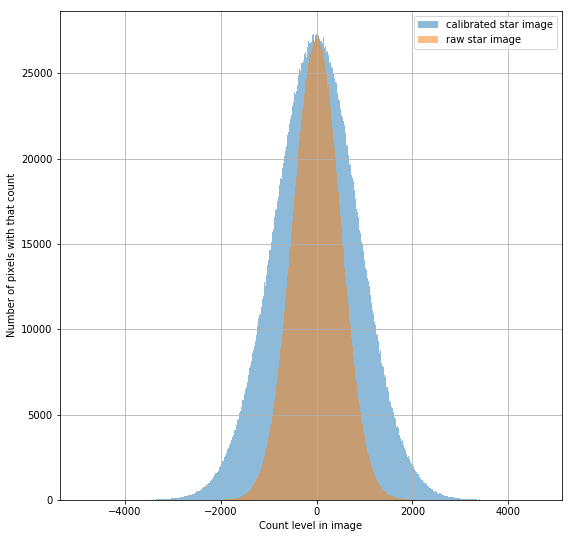

In [11]:
plt.figure(figsize=(9, 9))
hist(calibrated_stars.flatten(), bins='freedman', label='calibrated star image', alpha=0.5)
hist(stars_with_noise.flatten(), bins='freedman', label='raw star image', alpha=0.5)
plt.legend()
plt.grid()
plt.xlabel('Count level in image')
plt.ylabel('Number of pixels with that count');